<a href="https://cognitiveclass.ai"><img src = "https://ibm.box.com/shared/static/9gegpsmnsoo25ikkbl4qzlvlyjbgxs5x.png" width = 400> </a>

## **IBM Data Science Professional Certificate Capstone project**



## Table of contents
* [1. Introduction](#introduction)
* [2. Data Acquisition](#data)
* [3. Methodology](#methodology)
* [4. Conclusion](#conclusion)

## 1.Introduction:<a name="introduction"></a>
### 1.1. Background
<p style="text-align: right"> The main issue in starting a new business in food or retail or some other industry that needs to be in touch with customers is finding a suitable location. Traditionally, people used to make up their minds based on words of mouth of others  no matter of how reliable they were. Moreover, since national and global businesses as well as franchises can't rely on that method to make this underlying decision, the demand for a modern method seems obvious. Data Science as the warrior for unknown and vague issues all around the science come to the field to propose a solution for making a change in the decision procedure.</p>

### 1.2. Business Problem

The main goal of this project is to locate the best possible place for a particular type of business like restaurant (it can be easily generalized to other types).  The target audience of this project could be various sized businesses with a broad scope of objectives planning to open a new center in one of the LGAs(Local Government Areas) of Sydney. For the purpose of generalization, top-level features will be analyzed for all LGAs of Australia. The result will be narrow down to NSW with some extra added features to make the decision more precise. The approach is based on a wide variety of features including population density, income of population, number of currently available businesses in that LGA at the related field which is provided through the foursquare web services and many others. 


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2. Data Acquisition <a name="data"></a>
### 2.1. Data Sources
The data is acquired from three legitimate sources for covering separate dimensions of problem. For the first part of analysis a comprehensive dataset of demography, income  and population density is needed. Census data from Australian Bureau of Statistics is the most reliable resource in this regard. These data after collecting and cleaning will be used for clustering LGAs all around australia based on those desired features.
Another source of data is used to more accurately indicate how dense the business of interest is in each LGA. This part is collected through Foursquare API web services for more specific and limited places.
For taking into account prospect future customers, a wide variety of different datasets could be used based on what the biz is about to provide. For instance, if it's a restaurant that cooks a certain kind of food for a specific appetite like Chinese food, it should check where they have dwelled. To make it more generalized, I've used the population projection up to 2036 for all of LGAs of Sydney provided by an NSW Government Planning and Environment. That would be the most reliable prediction data available for how the population is changing according to the demography of LGAs.
Fusion of these three data sources will let an analysis that took into account all concentration, income, density of prospect customers, and time dimensions. The result could be personalized for each business case study.


### 2.2. Data Cleaning
Census data from Australian Bureau of Statistics is a very large dataset and a selection between columns is needed for desired features. Each part of it is accessible through some .xls files including Population_Density, Economy_Industry, Income, Family_Community, and Land_Environment. Moreover, missing values that were found in the data is dropped due to small size of populations of LGAs. 
The provided data from NSW Government Planning and Environment is available as an .xlsx file for download from their site. The downloaded file includes different sheets and the desirable one is addressed using sheet_name argument in the read_excel function. The sheet also has extra cells with irrelevant information that has cropped using header,           usecols, and skipfooter. For missing data that were exists due to importing, elimination used because there were no valuable data in it. The result is a neat pandas dataframe of population projection. 
The RESTful API of foursquare location data provides the data as a  JSON file. For further analysis it should be converted to pandas dataframe. It’s accomplished using each LGA and corresponding latitude and longitude of each one that is provided after calling the API. 


The population projections file is available as an excel file and should be converted to pandas dataframe.

First Download the file from NSW Government Planning and Environment website.

In [2]:
!wget -q -O 'Pop_proj.xlsx' https://www.planning.nsw.gov.au/-/media/Files/DPE/Other/nsw-state-and-local-government-area-population-projections-2016-xls.xlsx?la=en
print('File Downloaded!')

File Downloaded!


The data is divided into some sheets, and the desired one is located in **LGA Summary** Sheet. Moreover, removing extras of the converted sheet, reseting the indexes, setting the column names is done in the cell below.

In [3]:
Population_Projection = pd.read_excel('Pop_proj.xlsx', 
                   sheet_name = 'LGA Summary',                    # The sheet of interest in excel file
                   header = 9,                                    # Number of header rows without data
                   usecols = [i for i in range(6)],               # Number of columns with population data
                   index_col = 0,                                 # Setting the LGAs as index of Dataframe
                   skipfooter = 104,                              # Number of blank footer rows
                  )
Population_Projection.dropna(inplace = True)                                     # NAs are blank inline rows
Population_Projection = Population_Projection.astype(int)                        # The data is populations so it is integer
Population_Projection.drop(index = 'Rockdale (C)', inplace = True)               # Remove obsolete data from DataFrame  

Population_Projection.rename(lambda x: 'Population-Projection-' + str(x) ,axis = 1, inplace=True)
# Renaming mismatched column names in case of compatibility with other sources of data
Population_Projection.rename(index = {'Botany Bay (C)' : 'Bayside (A)',
                                      'Campbelltown (C)' : 'Campbelltown (C) (NSW)',
                                      'Canterbury-Bankstown' : 'Canterbury-Bankstown (A)',
                                      'Cumberland' : 'Cumberland (A)',
                                      'Georges River' : 'Georges River (A)',
                                      'Hornsby' : 'Hornsby (A)',
                                      'Inner West' : 'Inner West (A)',
                                      'Northern Beaches' : 'Northern Beaches (A)',
                                      'Parramatta' : 'Parramatta (C)',
                                      'The Hills' : 'The Hills Shire (A)'}, inplace=True)
Population_Projection.index.name = 'LGA'
Population_Projection.head()                                      # Display the head

,Population-Projection-2011,Population-Projection-2016,Population-Projection-2021,Population-Projection-2026,Population-Projection-2031
LGA,,,,,
Blacktown (C),312350,349050,387200,433500,475800
Blue Mountains (C),78550,82000,83000,84700,86950
Bayside (A),41500,48450,59300,65000,68950
Burwood (A),34200,38850,44900,49150,53500
Camden (A),58450,80900,109400,147850,185600


The Census data file is available as a number of excel files and should be converted to pandas dataframe as well. In the following cells each part of this data is loaded and cleaned to take for further processing. (There are other APIs for obtaining data from these resources, but here for the purpose of exercising, I import the files one by one directly.

First excel file is Population Density of each LGA

In [4]:
population_density_LGA = pd.read_excel('http://www.ausstats.abs.gov.au/ausstats/subscriber.nsf/0/DA3CCFA8DA24A330CA25833F007ED34B/$File/14100ds0002_2011-17.xls',
                   header = 8,
                   usecols = [1, 2, 68, 77],
                   index_col=1,    
                   skipfooter = 7)
population_density_LGA.drop(index = [2011,2012,2013,2014,2015,2016], inplace=True)
population_density_LGA.columns=['LGA', 'Total_Population', 'Population_Density(Persons/km2)']
population_density_LGA.set_index('LGA', inplace = True)
population_density_LGA.replace(['-', 'NaN'], np.NaN, inplace=True)
# missing values of this dataframe are LGAs with very low population and can be eliminated safely. 
# The population could be check by below line of code for LGAs with NaN.
# population_density_LGA[population_density_LGA.isna().sum(axis=1).astype(bool)]['Total_Population']
population_density_LGA.drop(columns = 'Total_Population', inplace = True)
population_density_LGA.dropna(inplace = True)
print(population_density_LGA.shape)
population_density_LGA.head()

(502, 1)


,Population_Density(Persons/km2)
LGA,
Albury (C),173.1
Armidale Regional (A),3.5
Ballina (A),89.6
Balranald (A),0.1
Bathurst Regional (A),11.2


Below I will import related Economy and Industry status indexes for each LGA. These features measure the readiness of LGA for landing a new business.

In [5]:
Economy_Industry_LGA = pd.read_excel('http://www.ausstats.abs.gov.au/ausstats/subscriber.nsf/0/A5FD91EC40D5173ECA25833F007ED51E/$File/14100ds0004_2011-17.xls',
                                    header = 7,
                                    usecols =[1, 2, 24, 25, 38],
                                    index_col = 1,    
                                    skipfooter = 7)
Economy_Industry_LGA.drop(index = [2011,2012,2013,2014,2015,2016], inplace=True)
Economy_Industry_LGA.columns=['LGA', 'Retail_trade', 'Accommodation_Food Services', 'Total_Number_of_Businesses']
Economy_Industry_LGA.set_index('LGA', inplace=True)
Economy_Industry_LGA.replace(['-', 'NaN'], np.NaN, inplace=True)
# missing values of this dataframe are LGAs with very low population and can be eliminated safely
# The Number of businesses could be check by below line of code for LGAs with NaN.
# Economy_Industry_LGA[Economy_Industry_LGA.isna().sum(axis=1).astype(bool)]['Total_Number_of_Businesses']
Economy_Industry_LGA.dropna(inplace = True)
print(Economy_Industry_LGA.shape)
Economy_Industry_LGA.head()

(498, 3)


,Retail_trade,Accommodation_Food Services,Total_Number_of_Businesses
LGA,,,
Albury (C),279.0,215.0,4557.0
Armidale Regional (A),163.0,129.0,2908.0
Ballina (A),251.0,184.0,4244.0
Balranald (A),14.0,18.0,277.0
Bathurst Regional (A),196.0,146.0,3376.0


In the next cell, features of income level of population of each LGA is imported. Income is an important part of where to locate a business.

In [6]:
Income_LGA = pd.read_excel('http://www.ausstats.abs.gov.au/ausstats/subscriber.nsf/0/35BB170AADAD3B3FCA25833F007ED681/$File/14100ds0006_2011-17.xls',
                        header = 6,
                        usecols = [i for i in range(21)] + [i for i in range(27,37)] + [i for i in range(38,44)],
                        index_col = 2,    
                        skipfooter = 7,
                        na_values = '-')

Income_LGA.columns = Income_LGA.columns + ' (' + Income_LGA.iloc[0] + ')'
Income_LGA.drop(index = ['YEAR',2011,2012,2013,2014,2015,2017],columns = 'Unnamed: 0 (CODE)', inplace=True)
Income_LGA=Income_LGA.rename(columns={'Unnamed: 1 (LABEL)' : 'LGA'}).set_index('LGA')
Income_LGA.replace(['-', 'NaN'], np.NaN, inplace=True)
#missing values of this dataframe are LGAs with very low population and can be eliminated safely
# The Income of population could be check by below line of code for LGAs with NaN.
# Income_LGA[Income_LGA.isna().sum(axis=1).astype(bool)]['Total Employee income ($)'].sort_values(ascending=False)
Income_LGA.dropna(inplace = True)
print(Income_LGA.shape)
Income_LGA.head(5)

(499, 34)


,Employee income earners (no.),Employee income earners - median age (years),Total Employee income ($),Median Employee income ($),Mean Employee income ($),Employee income as main source of income (%),Own unincorporated business income earners (no.),Own unincorporated business income earners - median age (years),Total Own unincorporated business income ($),Median Own unincorporated business income ($),Mean Own unincorporated business income ($),Own unincorporated business income as main source of income (%),Investment income earners (no.),Investment income earners - median age (years),Total Investment income ($),Median Investment income ($),Mean Investment income ($),Investment income as main source of income (%),Total income earners (excl. Government pensions) (no.),Total income earners (excl. Government pensions and allowances) - median age (years),Total income (excl. Government pensions) ($),Median Total income (excl. Government pensions) ($),Mean Total income (excl. Government pensions) ($),Total income (excl. Government pensions and allowances) - P80/P20 (ratio),Total income (excl. Government pensions and allowances) - P80/P50 (ratio),Total income (excl. Government pensions and allowances) - P20/P50 (ratio),Total income (excl. Government pensions and allowances) - P10/P50 ( ratio),Total income (excl. Government pensions and allowances) - Gini coefficient (no.),Total income (excl. Government pensions and allowances) - Income share of top 5% of earners (%),Total income (excl. Government pensions and allowances) - Income share of top 10% of earners (%),Total income (excl. Government pensions and allowances) - Lowest Quartile (%),Total income (excl. Government pensions and allowances) - Second Quartile (%),Total income (excl. Government pensions and allowances) - Third Quartile (%),Total income (excl. Government pensions and allowances) - Highest Quartile (%)
LGA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albury (C),25821.0,39.0,1.313181e+09,45382.0,50857.0,76.8,3985.0,49.0,109457331.0,12133.0,27467.0,7.0,20093.0,47.0,169818553.0,262.0,8452.0,13.8,28814.0,43.0,1.567136e+09,45504.0,54388.0,4.42,1.75,0.40,0.16,0.442,19.6,30.0,24.8,27.8,27.5,19.9
Armidale Regional (A),13844.0,39.0,6.560097e+08,39733.0,47386.0,74.1,3147.0,53.0,57068263.0,7434.0,18134.0,9.3,11201.0,49.0,82946846.0,396.0,7405.0,14.7,15363.0,45.0,7.725087e+08,40733.0,50284.0,5.50,1.90,0.34,0.14,0.476,19.8,31.2,29.5,28.6,23.4,18.5
Ballina (A),19767.0,43.0,9.509522e+08,40397.0,48108.0,66.4,5158.0,51.0,134232566.0,12443.0,26024.0,11.6,18510.0,52.0,170579262.0,472.0,9216.0,18.9,24406.0,48.0,1.248911e+09,39782.0,51172.0,5.52,1.95,0.35,0.13,0.488,21.7,33.0,30.0,28.8,22.6,18.6
Balranald (A),966.0,42.0,4.082463e+07,39057.0,42262.0,68.8,378.0,50.0,14754147.0,20961.0,39032.0,19.2,781.0,49.0,6477254.0,212.0,8294.0,10.5,1167.0,45.0,6.080560e+07,42282.0,52104.0,3.91,1.72,0.44,0.16,0.470,22.7,32.9,25.3,30.8,28.9,14.9
Bathurst Regional (A),19871.0,40.0,1.084052e+09,47994.0,54554.0,78.9,3505.0,51.0,71312446.0,8815.0,20346.0,7.8,15045.0,47.0,97235901.0,208.0,6463.0,11.6,21410.0,44.0,1.220862e+09,47746.0,57023.0,4.59,1.82,0.40,0.16,0.439,18.1,28.7,23.8,26.2,26.0,24.0


Family and household, and the loneliness of household occupants is imported. This features could have impact on the number of times someone eat out at a restaurant. 

In [7]:
Family_Community_LGA = pd.read_excel('http://www.ausstats.abs.gov.au/ausstats/subscriber.nsf/0/4D6E973CE0080FA0CA25833F007EDA0B/$File/14100ds0012_2011-17.xls',
                                     header = 6,
                                     usecols =[1, 2, 3, 18, 20, 21]+ [i for i in range(23,28)] + [29,41,42,53] + [i for i in range(57,60)] + [i for i in range(68,76)] ,
                                     index_col = 1,    
                                     skipfooter = 7)
                                   
Family_Community_LGA.columns = Family_Community_LGA.columns + ' (' + Family_Community_LGA.iloc[0] + ')'
Family_Community_LGA.drop(index = ['YEAR',2011,2012,2013,2014,2015], inplace=True)
Family_Community_LGA=Family_Community_LGA.rename(columns={'Unnamed: 1 (LABEL)' : 'LGA'}).set_index('LGA')
Family_Community_LGA.replace(['-', 'NaN'], np.NaN, inplace=True)
#missing values of this dataframe are LGAs with very low population and can be eliminated safely
#The population could be check by below line of code for LGAs with NaN for more than 200 persons
# (Family_Community_LGA[Family_Community_LGA.isna().sum(axis=1).astype(bool)]['Persons (no.)'] > 200 )
Family_Community_LGA.dropna(inplace = True)
print(Family_Community_LGA.shape)
Family_Community_LGA.head(5)

(482, 24)


,Persons (no.),Lone person households (no.),Family households (no.),Total households (no.),Couple families with children under 15 and/or dependent students (no.),Couple families with non-dependent children only (no.),Couple families without children (no.),"One parent families, children under 15 &/or dependent students (no.)","One parent families, non-dependent children only (no.)",Total families (no.),Average monthly household rental payment ($),Average monthly household mortgage payment ($),Separate house (no.),Owned Outright (%),Owned with a mortgage (%),Rented (%),Australia SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),Australia SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),Australia SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),Australia SEIFA decile ranking - Index of Economic Resources (IER) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),State SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),State SEIFA decile ranking - Index of Economic Resources (IER) (no.)
LGA,,,,,,,,,,,,,,,,,,,,,,,,
Albury (C),9906.0,6020.0,12674.0,19495.0,4354.0,799.0,5235.0,1582.0,676.0,12829,1049.0,1535.0,15634,30.2,32.3,33.7,5.0,5.0,6,3,6.0,5.0,6.0,3.0
Armidale Regional (A),4229.0,2983.0,6803.0,10276.0,2256.0,416.0,2867.0,853.0,389.0,6912,1103.0,1564.0,8689,34.4,26.0,36.1,6.0,7.0,9,3,6.0,7.0,8.0,3.0
Ballina (A),7768.0,4594.0,11067.0,16220.0,3321.0,764.0,5187.0,1225.0,662.0,11297,1476.0,1809.0,11223,41.0,26.5,28.0,8.0,8.0,8,7,8.0,8.0,8.0,7.0
Balranald (A),210.0,224.0,563.0,807.0,190.0,42.0,248.0,54.0,32.0,570,586.0,1019.0,734,41.4,24.6,29.7,3.0,3.0,2,4,3.0,3.0,1.0,4.0
Bathurst Regional (A),8267.0,3884.0,9934.0,14411.0,3583.0,727.0,3885.0,1276.0,531.0,10136,1177.0,1752.0,12166,32.5,33.7,30.7,6.0,7.0,7,6,7.0,7.0,7.0,7.0


Another part of the data is area of the LGA. It could be used as a feature as well as a useful quantity for calculating Foursquare request parameters

In [8]:
Land_Environment_LGA = pd.read_excel('http://www.ausstats.abs.gov.au/ausstats/subscriber.nsf/0/E0CC3CCFC1D3E610CA25833F007EDBAB/$File/14100ds0016_2011-17.xls',
                                     header = 6,
                                     usecols = [1,2,3],
                                     index_col = 1,    
                                     skipfooter = 7)
                                    
Land_Environment_LGA.drop(index = ['YEAR',2014,2015,2016], inplace=True)
Land_Environment_LGA=Land_Environment_LGA.rename(columns={'Unnamed: 1' : 'LGA' , 'Unnamed: 3' : 'Land_Area'}).set_index('LGA')
Family_Community_LGA.replace(['-', 'NaN'], np.NaN, inplace=True)
Land_Environment_LGA.head(5)

,Land_Area
LGA,
Albury (C),30594.6
Armidale Regional (A),862070
Ballina (A),48493.9
Balranald (A),2.16907e+06
Bathurst Regional (A),381786


For further analysis let's aggregate the datasets into one dataframe

In [9]:
dfs = [population_density_LGA,               #Attaching the dataset
      Economy_Industry_LGA,
      Income_LGA,
      Land_Environment_LGA,
      Family_Community_LGA]
print(population_density_LGA.shape,          #Printing each dataframe shape
      Economy_Industry_LGA.shape,
      Income_LGA.shape,
      Land_Environment_LGA.shape,
      Family_Community_LGA.shape)

(502, 1) (498, 3) (499, 34) (557, 1) (482, 24)


As they have different shapes, various join structures lead to different results. I used inner join as the dropped samples where not LGAs with a high population, but they can be in the dataset per decision.

In [10]:
from functools import reduce
df = reduce(lambda left, right: pd.merge(left,right, on='LGA'),dfs)        # Using reduce method for joining 2 by 2
df = df.astype(float)                                                      # Normalizing datatypes 
print(df.shape)
df.head()

(452, 63)


,Population_Density(Persons/km2),Retail_trade,Accommodation_Food Services,Total_Number_of_Businesses,Employee income earners (no.),Employee income earners - median age (years),Total Employee income ($),Median Employee income ($),Mean Employee income ($),Employee income as main source of income (%),Own unincorporated business income earners (no.),Own unincorporated business income earners - median age (years),Total Own unincorporated business income ($),Median Own unincorporated business income ($),Mean Own unincorporated business income ($),Own unincorporated business income as main source of income (%),Investment income earners (no.),Investment income earners - median age (years),Total Investment income ($),Median Investment income ($),Mean Investment income ($),Investment income as main source of income (%),Total income earners (excl. Government pensions) (no.),Total income earners (excl. Government pensions and allowances) - median age (years),Total income (excl. Government pensions) ($),Median Total income (excl. Government pensions) ($),Mean Total income (excl. Government pensions) ($),Total income (excl. Government pensions and allowances) - P80/P20 (ratio),Total income (excl. Government pensions and allowances) - P80/P50 (ratio),Total income (excl. Government pensions and allowances) - P20/P50 (ratio),Total income (excl. Government pensions and allowances) - P10/P50 ( ratio),Total income (excl. Government pensions and allowances) - Gini coefficient (no.),Total income (excl. Government pensions and allowances) - Income share of top 5% of earners (%),Total income (excl. Government pensions and allowances) - Income share of top 10% of earners (%),Total income (excl. Government pensions and allowances) - Lowest Quartile (%),Total income (excl. Government pensions and allowances) - Second Quartile (%),Total income (excl. Government pensions and allowances) - Third Quartile (%),Total income (excl. Government pensions and allowances) - Highest Quartile (%),Land_Area,Persons (no.),Lone person households (no.),Family households (no.),Total households (no.),Couple families with children under 15 and/or dependent students (no.),Couple families with non-dependent children only (no.),Couple families without children (no.),"One parent families, children under 15 &/or dependent students (no.)","One parent families, non-dependent children only (no.)",Total families (no.),Average monthly household rental payment ($),Average monthly household mortgage payment ($),Separate house (no.),Owned Outright (%),Owned with a mortgage (%),Rented (%),Australia SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),Australia SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),Australia SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),Australia SEIFA decile ranking - Index of Economic Resources (IER) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),State SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),State SEIFA decile ranking - Index of Economic Resources (IER) (no.)
LGA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albury (C),173.1,279.0,215.0,4557.0,25821.0,39.0,1.313181e+09,45382.0,50857.0,76.8,3985.0,49.0,109457331.0,12133.0,27467.0,7.0,20093.0,47.0,169818553.0,262.0,8452.0,13.8,28814.0,43.0,1.567136e+09,45504.0,54388.0,4.42,1.75,0.40,0.16,0.442,19.6,30.0,24.8,27.8,27.5,19.9,30594.6,9906.0,6020.0,12674.0,19495.0,4354.0,799.0,5235.0,1582.0,676.0,12829.0,1049.0,1535.0,15634.0,30.2,32.3,33.7,5.0,5.0,6.0,3.0,6.0,5.0,6.0,3.0
Armidale Regional (A),3.5,163.0,129.0,2908.0,13844.0,39.0,6.560097e+08,39733.0,47386.0,74.1,3147.0,53.0,57068263.0,7434.0,18134.0,9.3,11201.0,49.0,82946846.0,396.0,7405.0,14.7,15363.0,45.0,7.725087e+08,40733.0,50284.0,5.50,1.90,0.34,0.14,0.476,19.8,31.2,29.

checking number of LGAs in the merged dataframe

In [11]:
print(f'The dataframe has {df.shape[0]} LGAs in Australia')

The dataframe has 452 LGAs in Australia


#### Use geopy library to get the latitude and longitude values of Sydney.

In [12]:
address = 'Australia'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of Australia are {latitude}, {longitude}.')

The geograpical coordinate of Australia are -24.7761086, 134.755.


#### Use the same to get the latitude and longitude values of all LGAs.

In [14]:
LGAs = df.reset_index()['LGA']
Tiny_LGA = []
for LGA in LGAs:
    LGA_location= geolocator.geocode(LGA + ', NSW, Australia')            #Try different formats of calling an address
    if LGA_location == None:
        LGA_location= geolocator.geocode(LGA[:-4] + ', NSW, Australia')
    if LGA_location == None:
        LGA_location= geolocator.geocode(LGA)
    Tiny_LGA.append(LGA_location)
#   print(LGA_location)

Some of really tiny LGAs couldn't be found using Nominatim in geolocator. As their population is so small they can be eliminated safely to reach to the final version of LGA dataframe from census data.

In [15]:
LGA_Lat, LGA_Long, NLGA = [], [], []
for LGA in Tiny_LGA:
    if LGA != None: 
        if LGA.address[-9:] == 'Australia':            #check if some LGAs is retrieved from other continents
            NLGA.append(LGA)
            LGA_Lat.append(LGA.latitude) 
            LGA_Long.append(LGA.longitude) 
        else:
            NLGA.append(None)
    else:
        NLGA.append(None)
NLGA = pd.Series(NLGA)
df_cleaned = df.reset_index().drop(index = list(df.reset_index()[~(NLGA == NLGA)].index))
df_cleaned.set_index('LGA', inplace =True)
print(df.shape, df_cleaned.shape)

(452, 63) (430, 63)


#### Create a map of Sydney with LGAs superimposed on top.

In [16]:
# create map of Sydney using latitude and longitude values
map_Sydney = folium.Map(location=[latitude, longitude], zoom_start=4)

# add markers to map
for lat, lng, LGA in zip(LGA_Lat, LGA_Long, df_cleaned.reset_index()['LGA']):
    label = f'{LGA}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Sydney)  
    
map_Sydney

### 2.3. Dimensionality Reduction

Feature selection from raw data was totally based on intuition and there is an obvious need for eliminating redundant features. It can be seen from dataframe that features have large variations in their values and this has negative impact on KMeans clustering algorithm. Thus, first try to scale the features using StandardScaler from preprocessing tools of sklearn, and then selecting proper features, after that do a clustering to find out how good each LGA is for our business objective.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
df_scaled = df_cleaned
df_scaled[:] = StandardScaler().fit_transform(df_scaled[:])       # scale all the features to mean = 0 , std = 1
df_scaled.head()                 

,Population_Density(Persons/km2),Retail_trade,Accommodation_Food Services,Total_Number_of_Businesses,Employee income earners (no.),Employee income earners - median age (years),Total Employee income ($),Median Employee income ($),Mean Employee income ($),Employee income as main source of income (%),Own unincorporated business income earners (no.),Own unincorporated business income earners - median age (years),Total Own unincorporated business income ($),Median Own unincorporated business income ($),Mean Own unincorporated business income ($),Own unincorporated business income as main source of income (%),Investment income earners (no.),Investment income earners - median age (years),Total Investment income ($),Median Investment income ($),Mean Investment income ($),Investment income as main source of income (%),Total income earners (excl. Government pensions) (no.),Total income earners (excl. Government pensions and allowances) - median age (years),Total income (excl. Government pensions) ($),Median Total income (excl. Government pensions) ($),Mean Total income (excl. Government pensions) ($),Total income (excl. Government pensions and allowances) - P80/P20 (ratio),Total income (excl. Government pensions and allowances) - P80/P50 (ratio),Total income (excl. Government pensions and allowances) - P20/P50 (ratio),Total income (excl. Government pensions and allowances) - P10/P50 ( ratio),Total income (excl. Government pensions and allowances) - Gini coefficient (no.),Total income (excl. Government pensions and allowances) - Income share of top 5% of earners (%),Total income (excl. Government pensions and allowances) - Income share of top 10% of earners (%),Total income (excl. Government pensions and allowances) - Lowest Quartile (%),Total income (excl. Government pensions and allowances) - Second Quartile (%),Total income (excl. Government pensions and allowances) - Third Quartile (%),Total income (excl. Government pensions and allowances) - Highest Quartile (%),Land_Area,Persons (no.),Lone person households (no.),Family households (no.),Total households (no.),Couple families with children under 15 and/or dependent students (no.),Couple families with non-dependent children only (no.),Couple families without children (no.),"One parent families, children under 15 &/or dependent students (no.)","One parent families, non-dependent children only (no.)",Total families (no.),Average monthly household rental payment ($),Average monthly household mortgage payment ($),Separate house (no.),Owned Outright (%),Owned with a mortgage (%),Rented (%),Australia SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),Australia SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),Australia SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),Australia SEIFA decile ranking - Index of Economic Resources (IER) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),State SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),State SEIFA decile ranking - Index of Economic Resources (IER) (no.)
LGA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albury (C),-0.314937,-0.027253,0.019686,-0.049783,-0.024554,-0.484803,-0.099884,-0.040221,-0.298319,0.505781,-0.057439,-0.176782,-0.015523,0.077082,0.106549,-0.750404,-0.022074,-0.148831,-0.036298,-0.309976,-0.018461,-0.059400,-0.015469,-0.448683,-0.081383,-0.093804,-0.258487,-0.829364,-0.840905,0.935157,0.398941,-0.684769,-0.150957,-0.338930,-0.406798,0.527125,1.038204,-0.408856,-0.457282,-0.009699,0.205091,-0.027808,0.028092,-0.074933,-0.155751,0.010335,0.083621,-0.072670,-0.036058,-0.186596,-0.276565,0.096158,-0.594677,0.145883,0.429068,-0.360142,-0.356435,0.054756,-1.127381,0.049183,-0.308286,0.106877,-1.059790
Armidale Regional (A),-0.453072,-0.248256,-0.19626

For dimension reduction, different methodologies can be used. At first, I try to reduce the dimension of DataFrame using PCA. Below code wil generate the Scree Plot of percentages of each PCA Component.

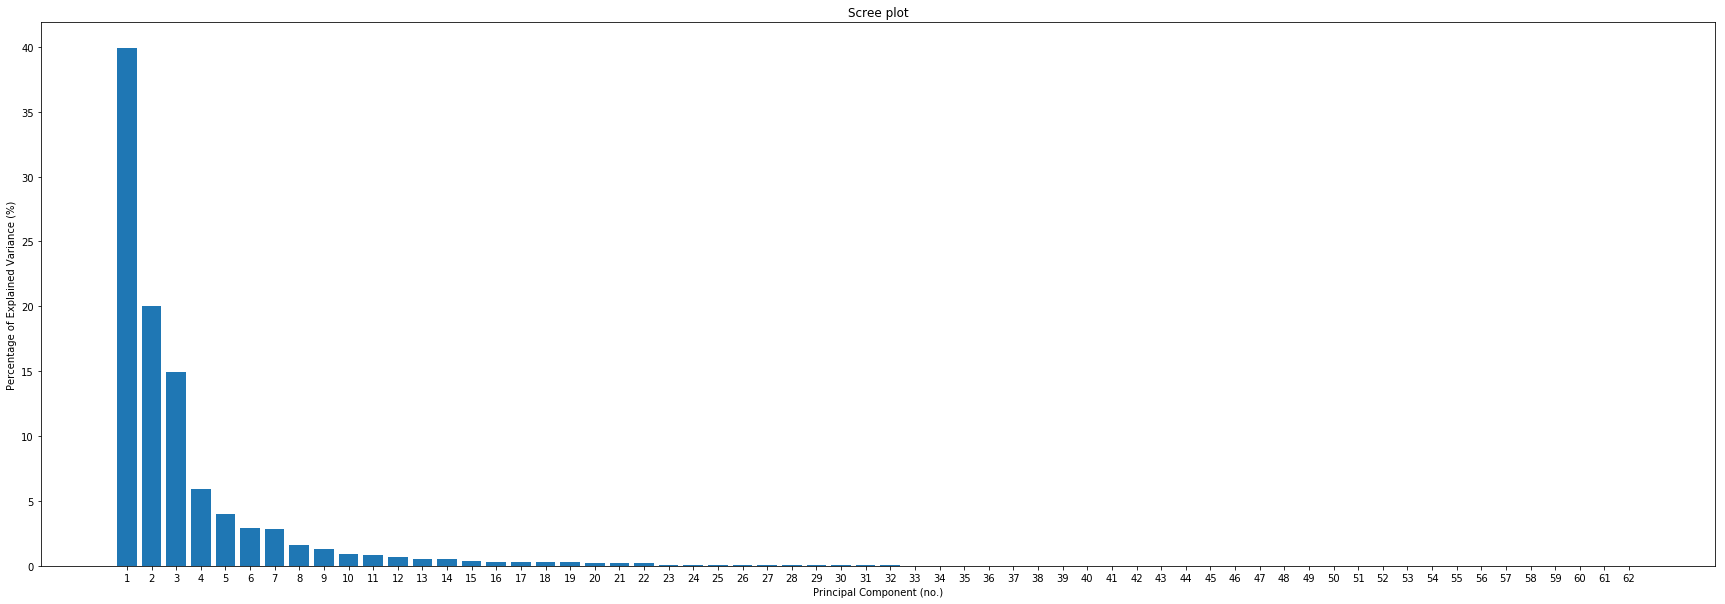

In [18]:
pca = PCA(n_components = "mle", svd_solver ="full")                            # Instantiate a PCA object
pca_data = pca.fit_transform(df_scaled)                                        # Fit the PCA on the DataFrame
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)            # Extract the ratio of each component
labels=[str(x) for x in range(1, len(per_var)+1)]                              # Generate labels for plot
plt.figure(figsize=(30,10))                                                    # Size of the figure
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)          
plt.ylabel('Percentage of Explained Variance (%)')
plt.xlabel('Principal Component (no.)')
plt.title('Scree plot')
plt.show()

As it can be seen from above graph almost half the features could safely be removed because of redundancy. However, for the sake of meaningfulness of features, I decided not to use projection of dimensions in this project. An alternative method could be removing of highly correlated features. In this way, just highly correlated features would remain in the dataframe. The following heatmap shows autocorrelation matrix of feature vector.


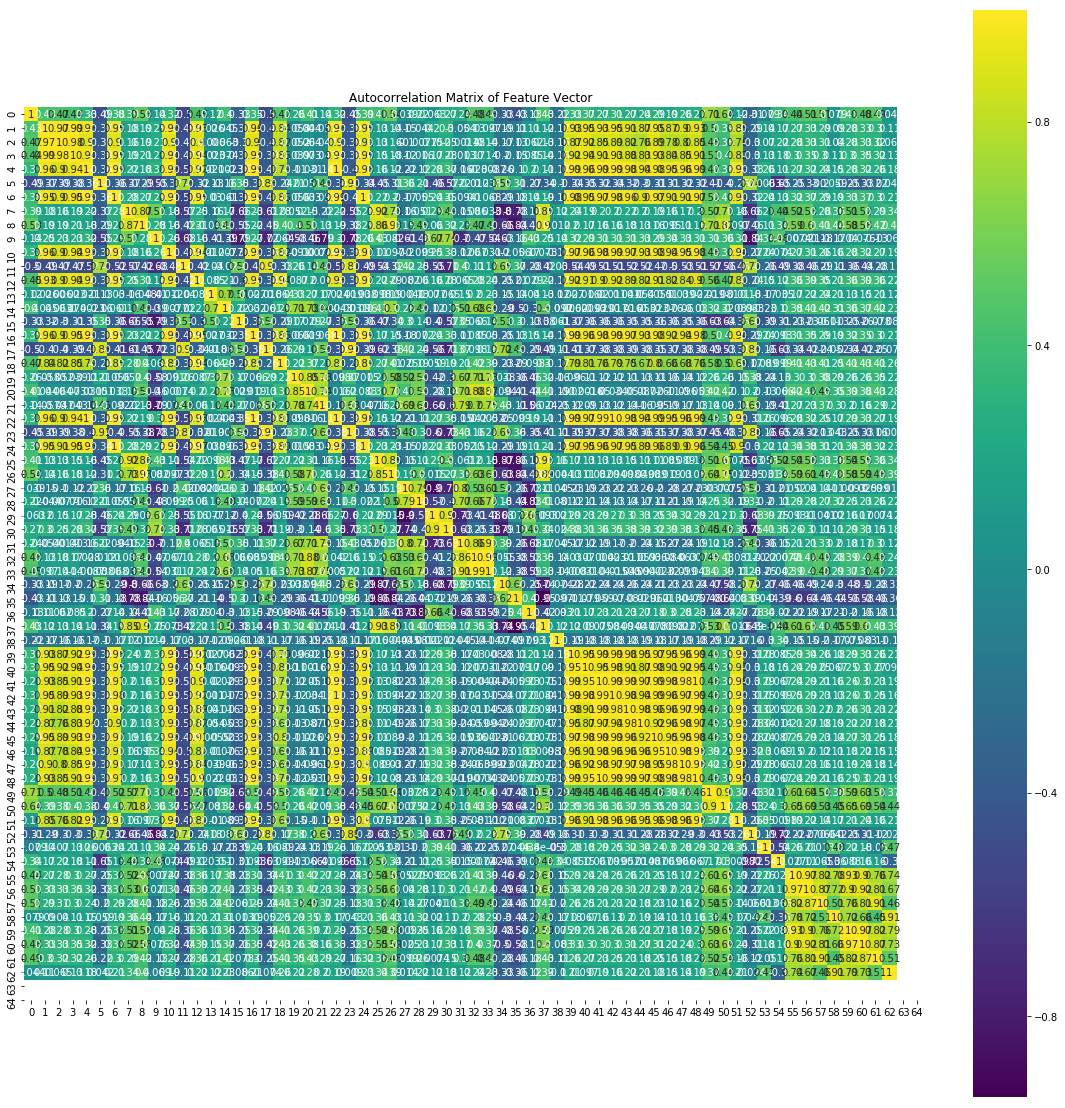

In [19]:
correlation = df_scaled.corr()                    # Calculating Autocorrelation Matrix of Dataframe
plt.figure(figsize=(20,20))
plt.title('Autocorrelation Matrix of Feature Vector')
sns.heatmap(correlation , vmax=1, square=True, annot=True, cmap='viridis', xticklabels=range(65), yticklabels=range(65))

for retaining the best meaningful features, they will be selected manually but based on the hint of number highly correlated ones.

In [20]:
pd.options.display.max_colwidth = 100
pd.DataFrame([(correlation > 0.8).sum(), (correlation < -0.8).sum()]).T.reset_index().rename(columns={'index':'feature', 0:'number of highly positively correlated', 1:'number of highly negatively correlated'})

,feature,number of highly positively correlated,number of highly negatively correlated
0,Population_Density(Persons/km2),1,0
1,Retail_trade,22,0
2,Accommodation_Food Services,18,0
3,Total_Number_of_Businesses,22,0
4,Employee income earners (no.),21,0
5,Employee income earners - median age (years),3,0
6,Total Employee income ($),22,0
7,Median Employee income ($),4,1
8,Mean Employee income ($),6,1
9,Employee income as main source of income (%),1,1


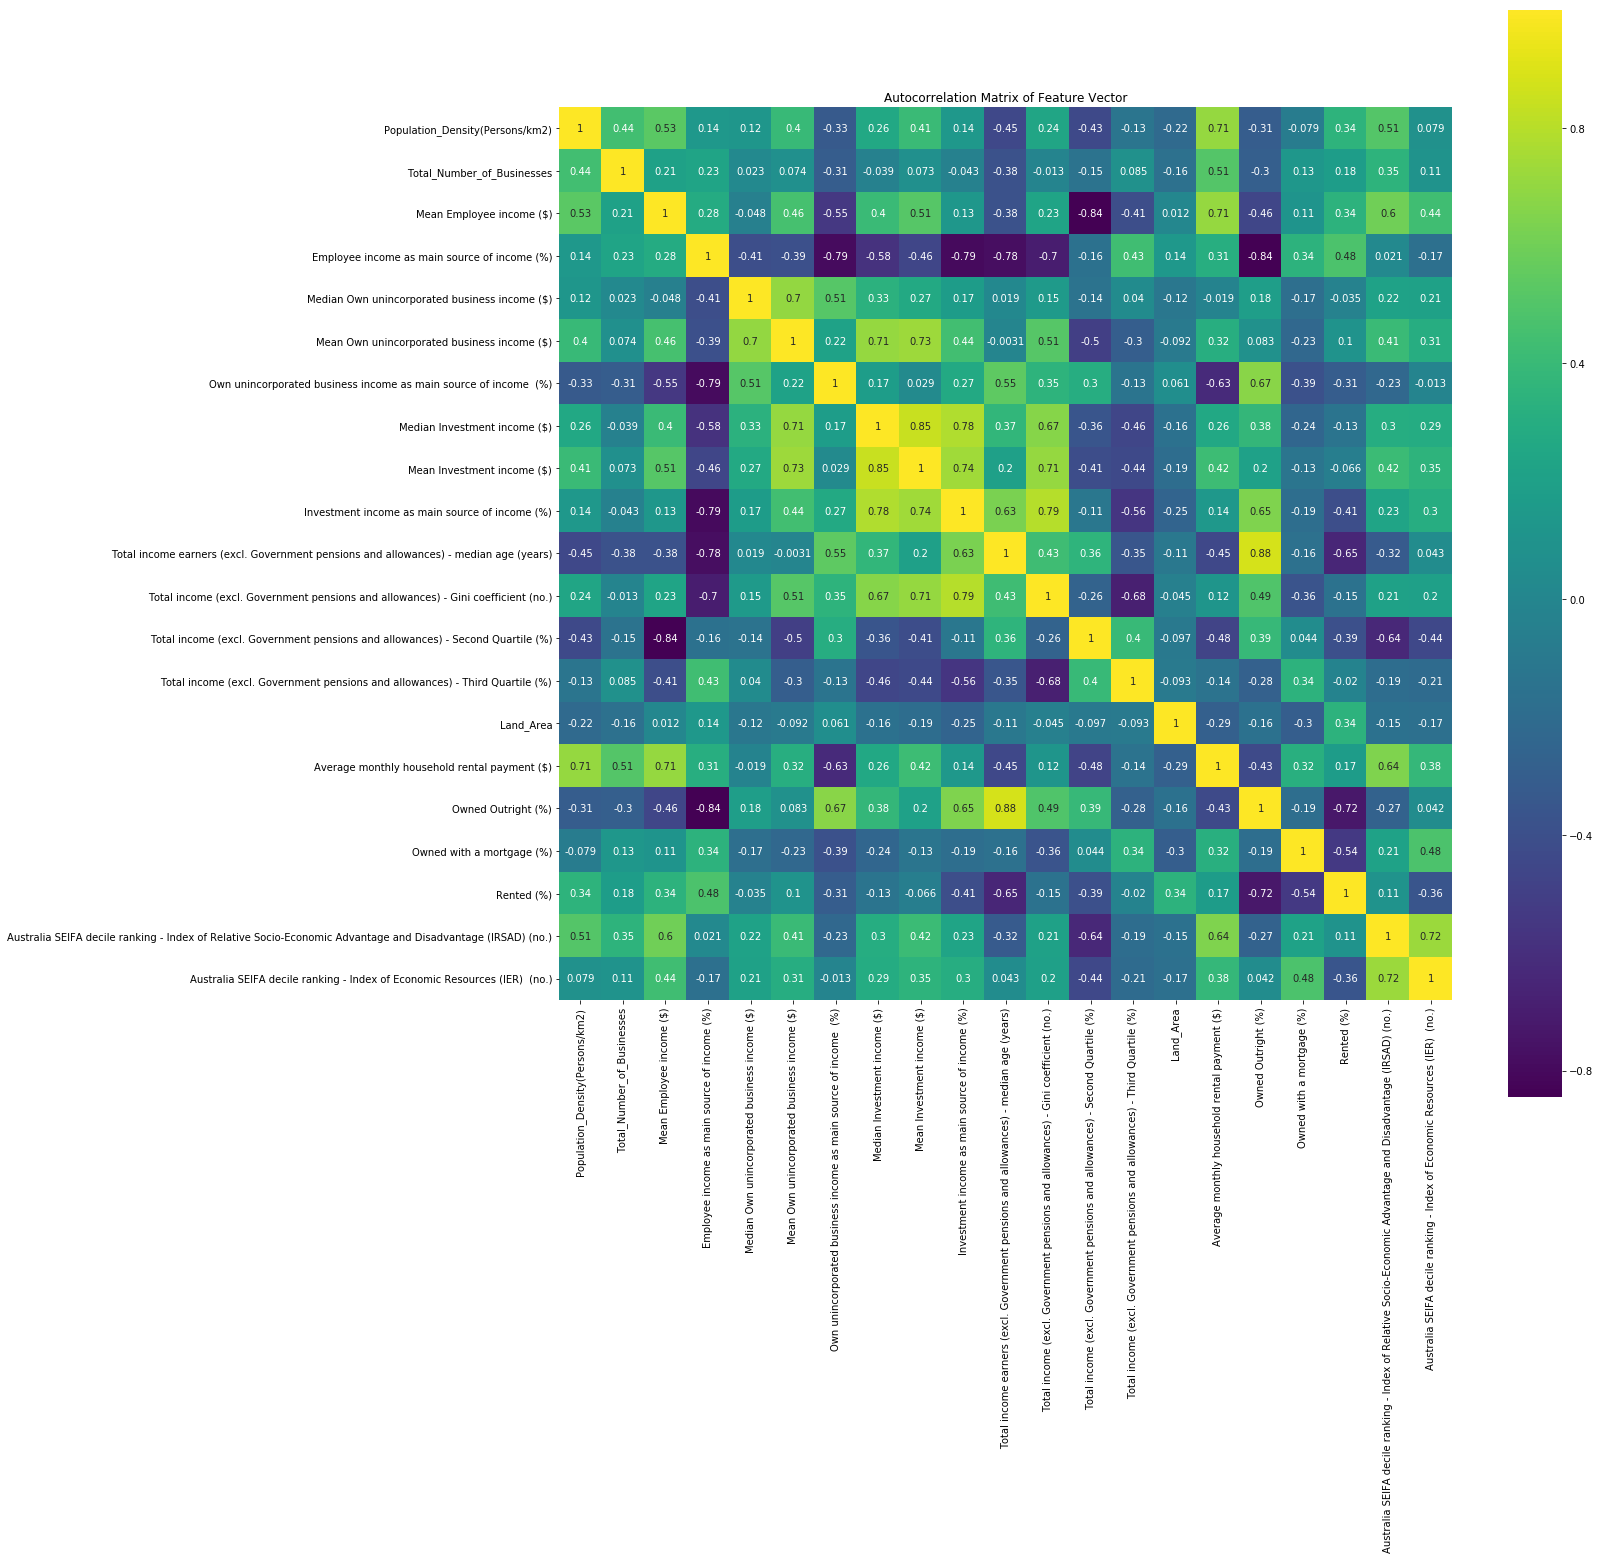

In [21]:
# Drop selected highly correlated features and generate the heatmap again
df_scaled = df_cleaned
df_scaled = df_scaled.drop(columns = df_scaled.columns[[1,2,4,6,10,12,16,18,22,24,39,40,41,42,43,44,45,46,47,48,51,17,22,25,26,37,5,7,11,55,57,59,60,61,62,50,33,34,32,30,28,29,27]])
correlation = df_scaled.corr()
plt.figure(figsize=(20,20))
plt.title('Autocorrelation Matrix of Feature Vector')
sns.heatmap(correlation , vmax=1, square=True, annot=True, cmap='viridis')

## 3. Methodology<a name="methodology"></a>
As the land is so diverse, it's better to narrow the region to Sydney Metropolitan Area LGA too. Obviously the same process can be accomplished for any other part of the map. Moreover, another feature that can have impact on the result of analysis is population projection that already imported into a separate DataFrame. I used the ratio between population in two years 2031 and 2016 and attached it to the Sydney Metropolitan Area reduced DataFrame

In [22]:
print(df_scaled.shape, Population_Projection.shape)
df_NSW_LGA = df_cleaned.loc[Population_Projection.index]
df_NSW_LGA['Population_Projection_ratio'] = Population_Projection['Population-Projection-2031']/Population_Projection['Population-Projection-2016']
df_NSW_LGA[:] = StandardScaler().fit_transform(df_NSW_LGA[:])

(430, 21) (33, 5)


In [23]:
print(f'The dataframe has {df_NSW_LGA.shape[0]} LGAs in Sydney Metropolitan Area')

The dataframe has 33 LGAs in Sydney Metropolitan Area


Now the DataFrame is ready to be clustered. First I used elbow method to determine number of clusters.

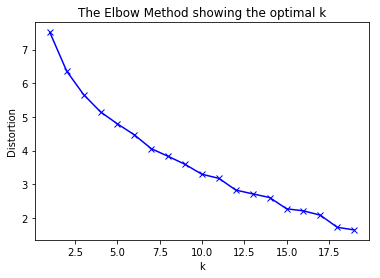

In [24]:
# clustering dataset
# determine k using elbow method

from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_NSW_LGA)
    distortions.append(sum(np.min(cdist(df_NSW_LGA, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_NSW_LGA.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As the graph shows the data is not perfectly separable but Let's take K=5. Cell below shows choosing that hyperparameter for  KMeans and running the algorithm to cluster the LGAs.

In [25]:
kclusters = 5
kmeans = KMeans(kclusters, random_state = 0).fit(df_NSW_LGA)
df_NSW_LGA['clusters'] = kmeans.labels_

Next step I plot the map with all LGAs with different colors based on their clusters on it.

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)
address = 'Sydney, Australia'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LGA_Lat, LGA_Long, df_NSW_LGA.reset_index()['LGA'], df_NSW_LGA.reset_index()['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
df1 = df.loc[Population_Projection.index]
df1['Population_Projection_ratio'] = Population_Projection['Population-Projection-2031']/Population_Projection['Population-Projection-2016']
df1['clusters'] = kmeans.labels_
df1[df_NSW_LGA.clusters == 3]

,Population_Density(Persons/km2),Retail_trade,Accommodation_Food Services,Total_Number_of_Businesses,Employee income earners (no.),Employee income earners - median age (years),Total Employee income ($),Median Employee income ($),Mean Employee income ($),Employee income as main source of income (%),Own unincorporated business income earners (no.),Own unincorporated business income earners - median age (years),Total Own unincorporated business income ($),Median Own unincorporated business income ($),Mean Own unincorporated business income ($),Own unincorporated business income as main source of income (%),Investment income earners (no.),Investment income earners - median age (years),Total Investment income ($),Median Investment income ($),Mean Investment income ($),Investment income as main source of income (%),Total income earners (excl. Government pensions) (no.),Total income earners (excl. Government pensions and allowances) - median age (years),Total income (excl. Government pensions) ($),Median Total income (excl. Government pensions) ($),Mean Total income (excl. Government pensions) ($),Total income (excl. Government pensions and allowances) - P80/P20 (ratio),Total income (excl. Government pensions and allowances) - P80/P50 (ratio),Total income (excl. Government pensions and allowances) - P20/P50 (ratio),Total income (excl. Government pensions and allowances) - P10/P50 ( ratio),Total income (excl. Government pensions and allowances) - Gini coefficient (no.),Total income (excl. Government pensions and allowances) - Income share of top 5% of earners (%),Total income (excl. Government pensions and allowances) - Income share of top 10% of earners (%),Total income (excl. Government pensions and allowances) - Lowest Quartile (%),Total income (excl. Government pensions and allowances) - Second Quartile (%),Total income (excl. Government pensions and allowances) - Third Quartile (%),Total income (excl. Government pensions and allowances) - Highest Quartile (%),Land_Area,Persons (no.),Lone person households (no.),Family households (no.),Total households (no.),Couple families with children under 15 and/or dependent students (no.),Couple families with non-dependent children only (no.),Couple families without children (no.),"One parent families, children under 15 &/or dependent students (no.)","One parent families, non-dependent children only (no.)",Total families (no.),Average monthly household rental payment ($),Average monthly household mortgage payment ($),Separate house (no.),Owned Outright (%),Owned with a mortgage (%),Rented (%),Australia SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),Australia SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),Australia SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),Australia SEIFA decile ranking - Index of Economic Resources (IER) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Disadvantage (IRSD) (no.),State SEIFA decile ranking - Index of Relative Socio-Economic Advantage and Disadvantage (IRSAD) (no.),State SEIFA decile ranking - Index of Education and Occupation (IEO) (no.),State SEIFA decile ranking - Index of Economic Resources (IER) (no.),Population_Projection_ratio,clusters
LGA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Blacktown (C),1489.2,1375.0,750.0,21136.0,177584.0,37.0,1.001693e+10,51696.0,56407.0,87.0,19666.0,41.0,383402581.0,12925.0,19496.0,6.3,111292.0,40.0,150441144.0,101.0,1352.0,5.7,179359.0,38.0,1.006904e+10,50647.0,56139.0,3.93,1.66,0.42,0.21,0.391,15.2,25.5,21.2,25.5,30.7,22.7,24004.9,67650.0,15362.0,83375.0,101107.0,40032.0,9098.0,21958.0,10022.0,5958.0,88519.0,1588.0,2204.0,78774.0,22.5,41.9,32.2,6.0,8.0,6.0,8.0,7.0,8.0,7.0,8.0,1.363128,3
Campbelltown (C) (NSW),527.4,566.0,286.0,8869.0,81668.0,38.0,4.361406e+09,49499.0,53404.0,87.1,8024.0,43.0,156519810.0,12415.0,19506.0,5.6,48584.0,43.0,88538522.0,109.0,1822.0,5.8,82078.0,40

Penrith(C) city Council is selected for further analysis and making a dataset from it's neighborhoods. At first scrape the wikipedia for suburbs and localities names.


In [54]:
import requests
from bs4 import BeautifulSoup as bs

df_localities = pd.DataFrame(columns = ['Suburbs_and_localities'])
file = requests.get('https://en.wikipedia.org/wiki/City_of_Penrith')
soup = bs(file.text)
# print(soup.prettify())
tags = soup.find_all('a')
for i, tag in enumerate(tags[69:110]):
    df_localities = df_localities.append({'Suburbs_and_localities' : tag.text}, ignore_index=True)
df_localities.head()

,Suburbs_and_localities
0,Agnes Banks
1,City of Hawkesbury
2,Badgerys Creek
3,City of Liverpool
4,Berkshire Park


Now that the suburbs and localities has been collected, it's time to get some data about them to see what businesses are currently working there. For this purpose Foursquare API is used. To make it work you need to put your own secret credentials got from Foursquare development section site.

In [41]:
CLIENT_ID = 'UBPFGQHZVY2WWM3OLRY5ZYYZEF0RW2ZPT1CMRRNVXC4LARPA' # your Foursquare ID
CLIENT_SECRET = 'RHQN04TQRRTTV3OWDCD2BS2M0IDDRDLW2HAOATZ41BWXK4BC' # your Foursquare Secret
VERSION = '20190217' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UBPFGQHZVY2WWM3OLRY5ZYYZEF0RW2ZPT1CMRRNVXC4LARPA
CLIENT_SECRET:RHQN04TQRRTTV3OWDCD2BS2M0IDDRDLW2HAOATZ41BWXK4BC


To generate a request to Foursquare API, a radius parameter is needed to retrieve the information in that area around the coordinates. we set the radius to 500 for now.

In [43]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    LGA_Lat[0], 
    LGA_Long[0], 
    radius, 
    LIMIT,
    'Restaurant')
url 
# display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=UBPFGQHZVY2WWM3OLRY5ZYYZEF0RW2ZPT1CMRRNVXC4LARPA&client_secret=RHQN04TQRRTTV3OWDCD2BS2M0IDDRDLW2HAOATZ41BWXK4BC&v=20190217&ll=-35.7760502,148.0058255&radius=500&limit=100&query=Restaurant'

In [44]:
results = requests.get(url).json()
results
with open('neighbor.json', 'w') as f:
    json.dump(results, f, indent =2)

In [45]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [46]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Macs Mountain Cafe,Fish & Chips Shop,-35.775052,148.009166
1,La Roca,Restaurant,-35.775726,148.010393
2,Tumba Bakery,Bakery,-35.775190,148.010382
3,Dare to Bite,Café,-35.773665,148.010527


In [47]:
print(f'{nearby_venues.shape[0]} venues were returned by Foursquare.')

4 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the LGAs in Sydney.

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            'Restaurant')
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        print(len(results))
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each LGA and create a new dataframe called *LGA_venues*.

In [55]:
LGA_venues = getNearbyVenues(names=df_localities['Suburbs_and_localities'],
                                   latitudes=LGA_Lat,
                                   longitudes=LGA_Long
                                  )

Agnes Banks
3
City of Hawkesbury
20
Badgerys Creek
21
City of Liverpool
5
Berkshire Park
20
Caddens
100
Cambridge Gardens
2
Cambridge Park
5
Castlereagh
0
Claremont Meadows
81
Colyton
0
Cranebrook
0
Emu Heights
5
Emu Plains
0
Erskine Park
4
Glenmore Park
2
Jamisontown
8
Jordan Springs
100
Kemps Creek
19
Kingswood
4
Kingswood Park
35
Leonay
45
Llandilo
100
Londonderry
100
Luddenham
0
Mount Vernon
21
Mulgoa
100
North St Marys
0
Orchard Hills
4
Oxley Park
3
Penrith
0
Regentville
3
St Clair
4
St Marys
100
City of Blacktown
0
South Penrith
0
Wallacia
0
Wollondilly Shire
100
Werrington
0
Werrington County
6
Werrington Downs
100


#### Let's check the size of the resulting dataframe

In [56]:
print(LGA_venues.shape)
LGA_venues.head()

(1120, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agnes Banks,-35.776050,148.005825,Macs Mountain Cafe,-35.775052,148.009166,Fish & Chips Shop
1,Agnes Banks,-35.776050,148.005825,Tumba Bakery,-35.775190,148.010382,Bakery
2,Agnes Banks,-35.776050,148.005825,Dare to Bite,-35.773665,148.010527,Café
3,City of Hawkesbury,-30.514488,151.665656,Altitude Coffee Roastery,-30.513664,151.665225,Café
4,City of Hawkesbury,-30.514488,151.665656,Goldfish Bowl Bakery,-30.514174,151.662984,Café


Let's check how many venues were returned for each neighborhood

In [57]:
LGA_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agnes Banks,3,3,3,3,3,3
Badgerys Creek,21,21,21,21,21,21
Berkshire Park,20,20,20,20,20,20
Caddens,100,100,100,100,100,100
Cambridge Gardens,2,2,2,2,2,2
Cambridge Park,5,5,5,5,5,5
City of Hawkesbury,20,20,20,20,20,20
City of Liverpool,5,5,5,5,5,5
Claremont Meadows,81,81,81,81,81,81


#### Let's find out how many unique categories can be curated from all the returned venues

In [58]:
print(f'There are {len(LGA_venues["Venue Category"].unique())} uniques categories.')

There are 71 uniques categories.


In [59]:
# one hot encoding
LGA_onehot = pd.get_dummies(LGA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LGA_onehot['Neighborhood'] = LGA_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LGA_onehot.columns[-1]] + list(LGA_onehot.columns[:-1])
LGA_onehot = LGA_onehot[fixed_columns]

LGA_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burmese Restaurant,Café,Cambodian Restaurant,Cantonese Restaurant,Chinese Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pastelaria,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agnes Banks,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agnes Banks,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agnes Banks,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,City of Hawkesbury,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,City of Hawkesbury,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
LGA_onehot.shape

(1120, 72)

In [61]:
LGA_grouped = LGA_onehot.groupby('Neighborhood').mean().reset_index()
LGA_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burmese Restaurant,Café,Cambodian Restaurant,Cantonese Restaurant,Chinese Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pastelaria,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Agnes Banks,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.333333,0.000000,0.00,0.00,0.000000,0.000000,0.333333,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.333333,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000
1,Badgerys Creek,0.00,0.00,0.000000,0.00,0.047619,0.142857,0.00,0.095238,0.000000,0.00,0.00,0.047619,0.000000,0.285714,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.047619,0.000000,0.000000,0.000000,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.095238,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.047619,0.000000,0.00,0.000000,0.000000,0.047619,0.047619,0.00,0.047619,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000
2,Berkshire Park,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.05,0.000000,0.000000,0.400000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.050000,0.00,0.00,0.050000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.150000,0.000000,0.00,0.150000,0.000000,0.100000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.050000,0.00,0.000000,0.000000
3,Caddens,0.00,0.00,0.000000,0.01,0.020000,0.070000,0.01,0.060000,0.000000,0.01,0.00,0.030000,0.000000,0.270000,0.00,0.00,0.040000,0.000000,0.00,0.00,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.00,0.00,0.01,0.00,0.000000,0.010000,0.00,0.060000,0.060000,0.00,0.01,0.00,0.02,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.00,0.040000,0.000000,0.01,0.040000,0.000000,0.020000,0.030000,0.00,0.000000,0.00,0.00,0.00,0.01,0.010000,0.000000,0.00,0.01,0.090000,0.00,0.020000,0.000000
4,Cambridge Gardens,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000
5,Cambridge Park,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000

In [62]:
LGA_grouped.set_index('Neighborhood', inplace = True)
LGA_restaurant = LGA_grouped.loc[:,LGA_grouped.columns[LGA_grouped.columns.str.contains('.*Restaurant')]]

In [67]:
LGA_grouped['LGA_Restaurant'] = LGA_restaurant.sum(axis = 1)

In [68]:
LGA_grouped

,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burmese Restaurant,Café,Cambodian Restaurant,Cantonese Restaurant,Chinese Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,Noodle House,Pastelaria,Pizza Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Shanghai Restaurant,Snack Place,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,LGA_Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agnes Banks,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.333333,0.000000,0.00,0.00,0.000000,0.000000,0.333333,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.333333,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000
Badgerys Creek,0.00,0.00,0.000000,0.00,0.047619,0.142857,0.00,0.095238,0.000000,0.00,0.00,0.047619,0.000000,0.285714,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.047619,0.000000,0.000000,0.000000,0.00,0.047619,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.095238,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.047619,0.000000,0.00,0.000000,0.000000,0.047619,0.047619,0.00,0.047619,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.380952
Berkshire Park,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.05,0.000000,0.000000,0.400000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.050000,0.00,0.00,0.050000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.150000,0.000000,0.00,0.150000,0.000000,0.100000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.050000,0.00,0.000000,0.000000,0.250000
Caddens,0.00,0.00,0.000000,0.01,0.020000,0.070000,0.01,0.060000,0.000000,0.01,0.00,0.030000,0.000000,0.270000,0.00,0.00,0.040000,0.000000,0.00,0.00,0.000000,0.01,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.00,0.00,0.00,0.01,0.00,0.000000,0.010000,0.00,0.060000,0.060000,0.00,0.01,0.00,0.02,0.000000,0.000000,0.000000,0.00,0.00,0.01,0.00,0.040000,0.000000,0.01,0.040000,0.000000,0.020000,0.030000,0.00,0.000000,0.00,0.00,0.00,0.01,0.010000,0.000000,0.00,0.01,0.090000,0.00,0.020000,0.000000,0.550000
Cambridge Gardens,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,1.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000
Cambridge Park,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00

Now based on type of restaurant that the business willing to found, they can choose or make another clustering on this new dataframe.

## 4.Conclusion <a name="conclusion"></a>
In this project a top-down approach to make a decision using data science has been proposed. At first, it is essential to select reliable and comprehensive set of features to feed to the other steps. almost all the algorithms need eliminating of redundancy between features. Thus, an essential part of the project would be feature engineering. Next, clustering the dataset will make the options easier to be chosen. by narrowing down the response space based on previous stage, other more precise features could be added to the DataFrame to make it richer. These new features are opted from Foursquare API and are related to the venue of interest like restaurant.    
Based on the result of the analysis, it's possible to define a new metric for the best place to found the new business. Moreover, some other features like how people of that LGA tend to eat out, or something like their income or number of family members, ethnicity could make our analysis more precise. By taking data from the prosperity level of businesses into account from premium calls of Foursquare API, a better outcome can be reached.
Based on this data examining, someone can check how one LGA is growing and what is the status of current businesses available.

This concludes the project.
Thank you.